# Price Prediction Using K-Nearest Neighbors (kNN)

*Your goal is to use K-nearest neighbors to build a predictive model for price, given mileage, separately for each of two trim levels: 350 and 65 AMG.*

In [ ]:
library(tidyverse)
library(tidymodels)
library(tidyquant)
library(kknn)
library(lubridate)
library(scales)
library(Hmisc)

In [3]:
# Import 
sclass <- read_csv("../../ECO395M/data/sclass.csv") %>% 
  filter(trim %in% c("350", "65 AMG"))

Parsed with column specification:
cols(
  id = col_double(),
  trim = col_character(),
  subTrim = col_character(),
  condition = col_character(),
  isOneOwner = col_logical(),
  mileage = col_double(),
  year = col_double(),
  color = col_character(),
  displacement = col_character(),
  fuel = col_character(),
  state = col_character(),
  region = col_character(),
  soundSystem = col_character(),
  wheelType = col_character(),
  wheelSize = col_character(),
  featureCount = col_double(),
  price = col_double()
)



In [6]:
# Filter data
sclass350 <- sclass %>% filter(trim == "350")
sclass65 <- sclass %>% filter(trim == "65 AMG")

# Table
sclass %>% 
  group_by(trim) %>% 
  tally()

trim,n
<chr>,<int>
350,416
65 AMG,292


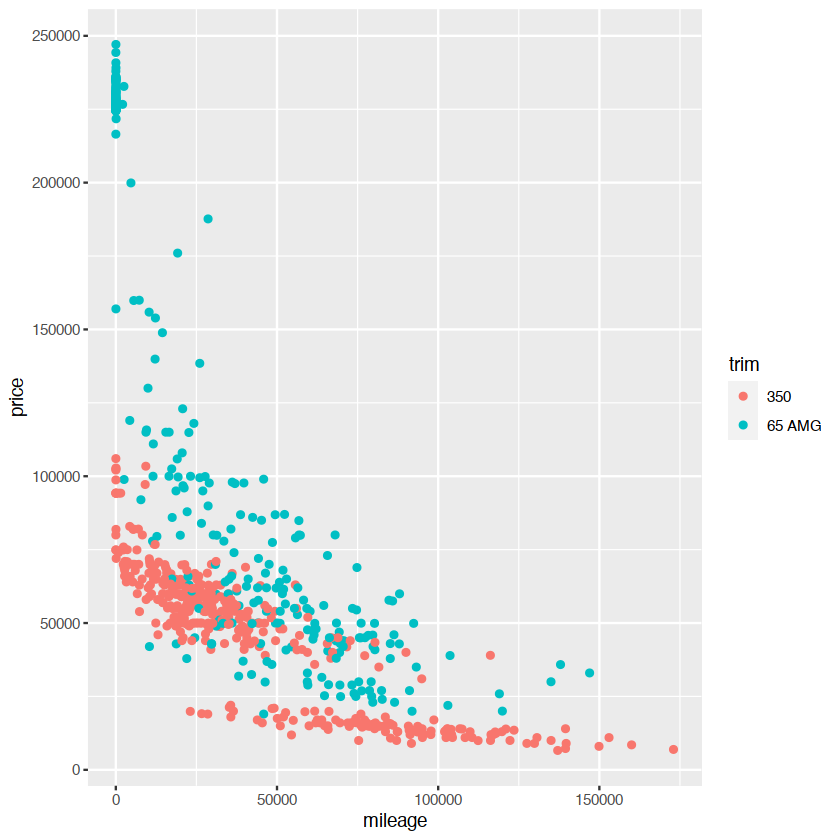

In [7]:
sclass %>% 
  ggplot() + 
  geom_point(aes(x = mileage, y = price, color = trim))

In [8]:
set.seed(350)

# split into train/test
sclass350_split <- initial_split(sclass350, prop = 0.6, strata = price)
sclass350_train <- training(sclass350_split)
sclass350_test <- testing(sclass350_split)

sclass65_split <- initial_split(sclass65, prop = 0.6, strata = price)
sclass65_train <- training(sclass65_split)
sclass65_test <- testing(sclass65_split)

## 350 Trim

In [9]:
sclass350_recipe <- recipe(price ~ mileage, data = sclass350_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

sclass350_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

sclass350_vfold <- vfold_cv(sclass350_train, v = 2, strata = price)

sclass350_wkflw <- workflow() %>%
  add_recipe(sclass350_recipe) %>%
  add_model(sclass350_spec)

In [10]:
gridvals <- tibble(neighbors = seq(1, 124))

sclass350_results <- sclass350_wkflw %>%
  tune_grid(resamples = sclass350_vfold, grid = gridvals) %>%
  collect_metrics()


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice



Attaching package: ‘vctrs’


The following object is masked from ‘package:dplyr’:

    data_frame


The following object is masked from ‘package:tibble’:

    data_frame


! Fold1: preprocessor 1/1, model 1/1: 124 samples were requested but there were 1...

! Fold2: preprocessor 1/1, model 1/1: 124 samples were requested but there were 1...



Warning message:
“Removed 49 rows containing missing values (geom_point).”


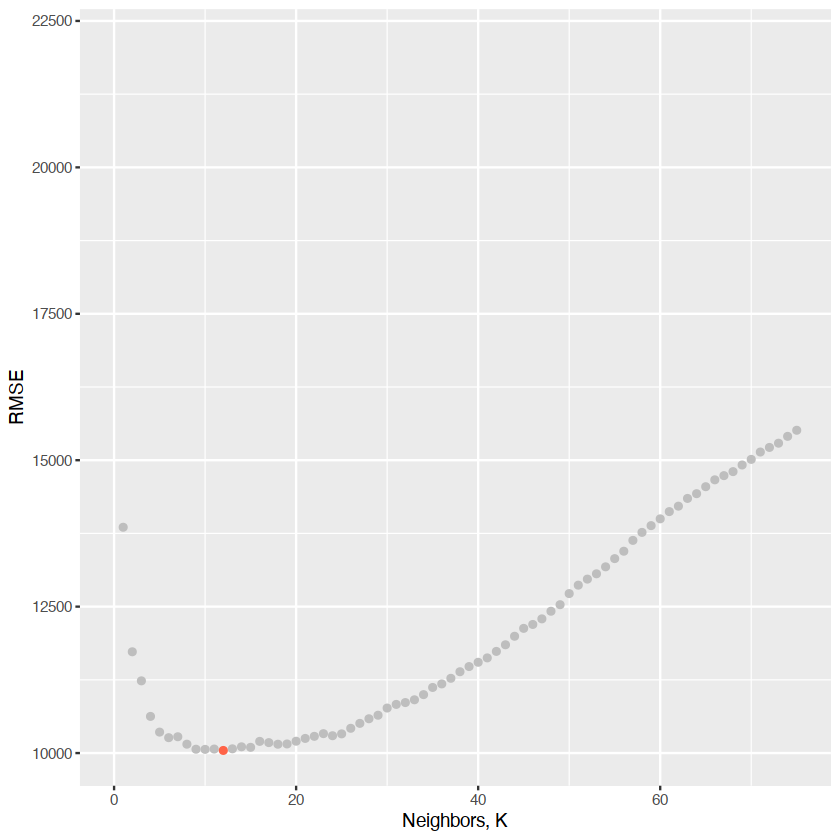

In [12]:
kp1 <- sclass350_results %>% 
  filter(.metric == "rmse") %>% 
  select(neighbors, mean) %>% 
  mutate(highlight = if_else(mean == min(mean), "h", "l")) %>% 
  ggplot() + 
  geom_point(aes(x = neighbors, y = mean, color = highlight)) + 
  scale_color_manual(values = c("tomato", "grey")) +
  xlim(0, 75) + 
  labs(x = "Neighbors, K", y = "RMSE") 

kp2 <- kp1 + 
  theme(legend.position = "none")

kp2

In [14]:
# show only the row of minimum RMSPE
sclass350_min <- sclass350_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean)) 

sclass350_min 

print(paste("The smallest rmse occurs at K =", as.numeric(sclass350_min[,1])))

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,rmse,standard,10044.45,2,214.4052,Preprocessor1_Model012


[1] "The smallest rmse occurs at K = 12"


In [15]:
set.seed(350)
kmin <- sclass350_min %>% pull(neighbors)
sclass350_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

sclass350_fit <- workflow() %>%
  add_recipe(sclass350_recipe) %>%
  add_model(sclass350_spec) %>%
  fit(data = sclass350_train)

sclass350_summary <- sclass350_fit %>%
  predict(sclass350_test) %>%
  bind_cols(sclass350_test) %>%
  metrics(truth = price, estimate = .pred)

sclass350_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.077597e+04
rsq,standard,7.832418e-01
mae,standard,7.671877e+03


Overlaid fitted model for optimal value of K, where red is the 65 AMG trim and blue is the 350 trim.

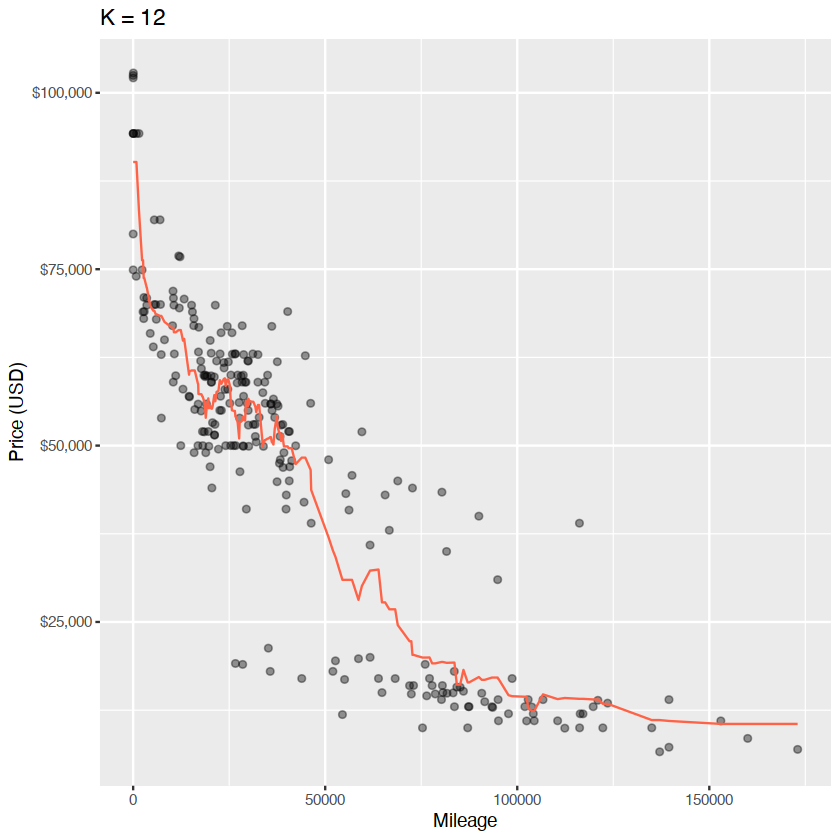

In [17]:
set.seed(350)
sclass350_preds <- sclass350_fit %>%
  predict(sclass350_train) %>%
  bind_cols(sclass350_train)

plot_final <- ggplot(sclass350_preds, aes(x = mileage, y = price)) +
  geom_point(alpha = 0.4) +
  xlab("Mileage") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  geom_line(data = sclass350_preds, aes(x = mileage, y = .pred), 
            color = "tomato") +
  ggtitle(paste0("K = ", kmin)) 

plot_final

## 65 AMG Trim

In [18]:
# 65 AMG
sclass65_recipe <- recipe(price ~ mileage, data = sclass65_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

sclass65_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

sclass65_vfold <- vfold_cv(sclass65_train, v = 2, strata = price)

sclass65_wkflw <- workflow() %>%
  add_recipe(sclass65_recipe) %>%
  add_model(sclass65_spec)

In [19]:
gridvals <- tibble(neighbors = seq(1, 50))

sclass65_results <- sclass65_wkflw %>%
  tune_grid(resamples = sclass65_vfold, grid = gridvals) %>%
  collect_metrics()

RMSE v K

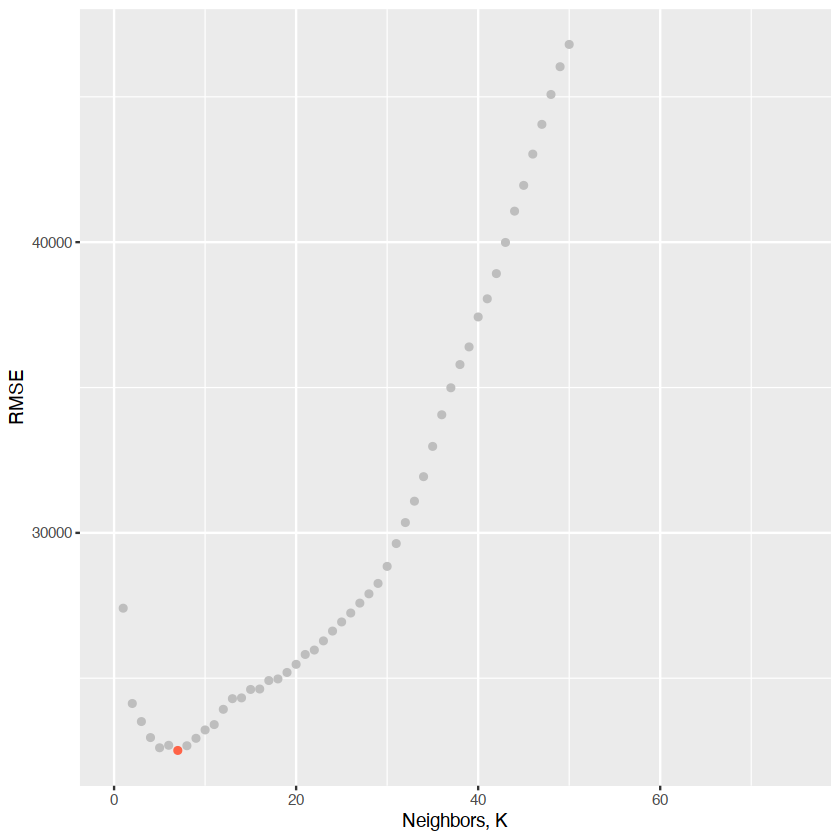

In [20]:
kp1 <- sclass65_results %>% 
  filter(.metric == "rmse") %>% 
  select(neighbors, mean) %>% 
  mutate(highlight = if_else(mean == min(mean), "h", "l")) %>% 
  ggplot() + 
  geom_point(aes(x = neighbors, y = mean, color = highlight)) + 
  scale_color_manual(values = c("tomato", "grey")) +
  xlim(0, 75) + 
  labs(x = "Neighbors, K", y = "RMSE") 

kp2 <- kp1 + 
  theme(legend.position = "none")

kp2

In [21]:
sclass65_min <- sclass65_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean)) 

sclass65_min 

print(paste("The smallest rmse occurs at K =", as.numeric(sclass65_min[,1])))

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,22514.13,2,1853.518,Preprocessor1_Model07


[1] "The smallest rmse occurs at K = 7"


In [22]:
set.seed(350)
kmin <- sclass65_min %>% pull(neighbors)
sclass65_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

sclass65_fit <- workflow() %>%
  add_recipe(sclass65_recipe) %>%
  add_model(sclass65_spec) %>%
  fit(data = sclass65_train)

sclass65_summary <- sclass65_fit %>%
  predict(sclass65_test) %>%
  bind_cols(sclass65_test) %>%
  metrics(truth = price, estimate = .pred)

sclass65_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.182021e+04
rsq,standard,9.276637e-01
mae,standard,1.397274e+04


Fitted model for optimal value of K

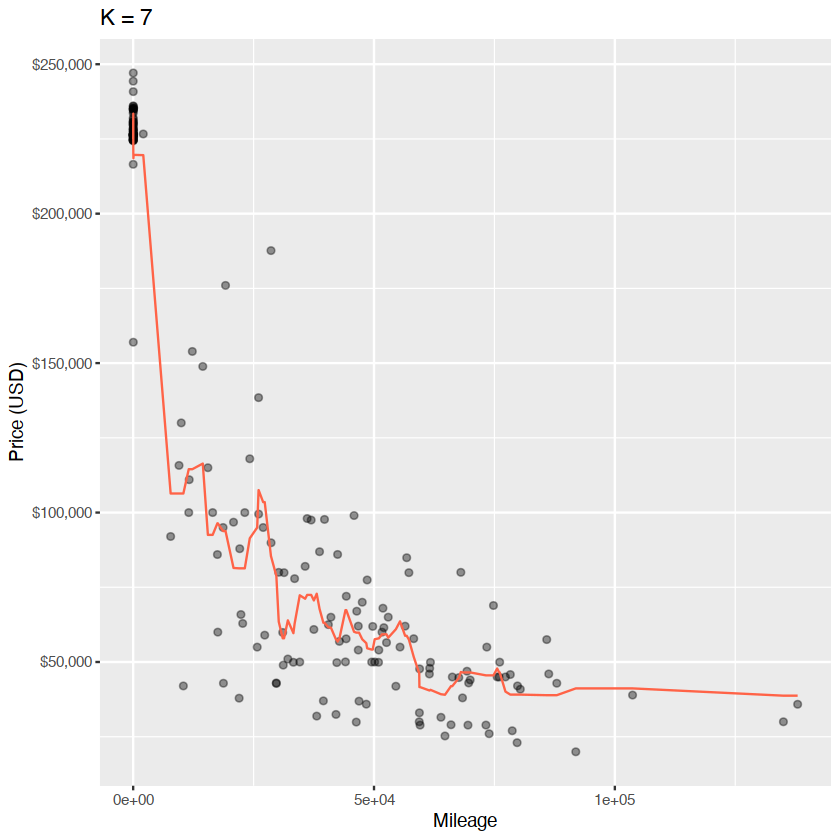

In [23]:
set.seed(350)
sclass65_preds <- sclass65_fit %>%
  predict(sclass65_train) %>%
  bind_cols(sclass65_train)

plot_final <- ggplot(sclass65_preds, aes(x = mileage, y = price)) +
  geom_point(alpha = 0.4) +
  xlab("Mileage") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  geom_line(data = sclass65_preds, aes(x = mileage, y = .pred), 
            color = "tomato") +
  ggtitle(paste0("K = ", kmin)) 

plot_final 

## Joint Plot

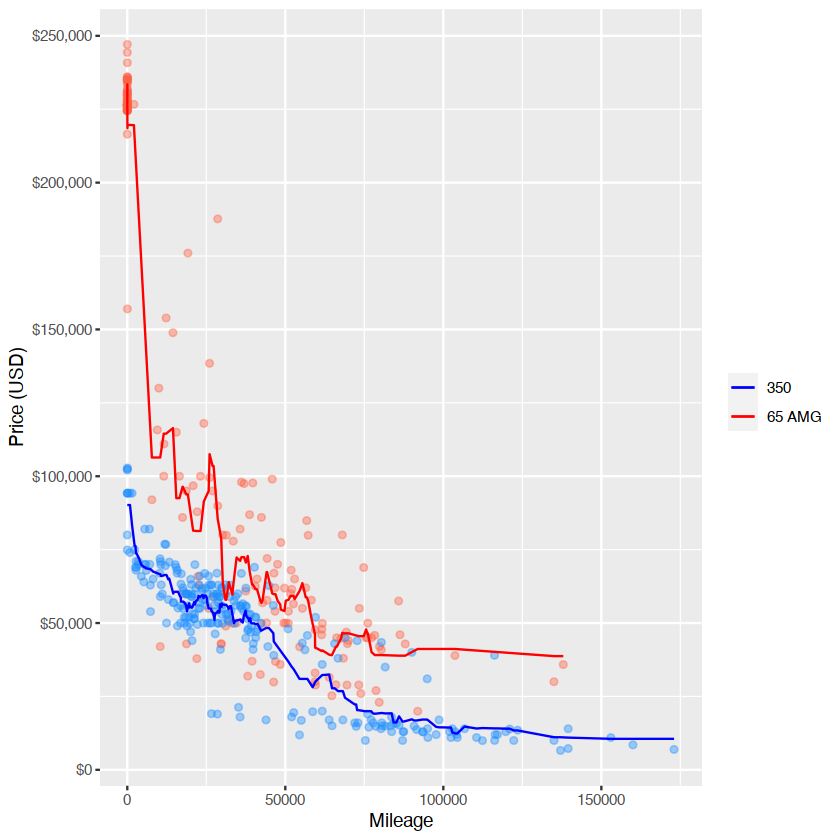

In [25]:
plot_joint <- ggplot() +
  geom_point(data = sclass65_preds, aes(x = mileage, y = price), color = "tomato", alpha = 0.4) +
  geom_point(data = sclass350_preds, aes(x = mileage, y = price), color = "dodgerblue", alpha = 0.4) +
  xlab("Mileage") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  geom_line(data = sclass65_preds, aes(x = mileage, y = .pred, color = "65 AMG")) +
  geom_line(data = sclass350_preds, aes(x = mileage, y = .pred, color = "350")) + 
  scale_color_manual(values = c("blue", "red"))

plot_joint + 
  theme(legend.title = element_blank())

In [ ]:
system.info()